In [2]:
from astropy.cosmology import FlatLambdaCDM
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft, pi

## Calculate distance
- for Abell 2744
- redshift z = 0.308
- 1,221 Mpc/h (3,982 Mly)

In [3]:
cosmo_flat = FlatLambdaCDM(H0=70.0, Om0=0.3, Tcmb0=2.7255)
z = 0.308
scale = cosmo_flat.kpc_proper_per_arcmin(z)
ang_r=(scale.value/60)
print('Kpc/arcsec at z=0.308',ang_r)
print(type(scale))
ang_Mpc_h = scale.value*60/1000
print(f"Mpc/h at {z=}: {ang_Mpc_h}")

Kpc/arcsec at z=0.308 4.5356240737371705
<class 'astropy.units.quantity.Quantity'>
Mpc/h at z=0.308: 16.328246665453815


In [23]:
# Open Image
kappa,header=pyfits.getdata('kappa_2.fits',header=True)
#print(header)
#for k,v in header.items():
#    print(f"{k}: {v}")

In [4]:
# Open Image
data_mass,header=pyfits.getdata('meanmass.fits',header=True)
for k,v in header.items():
    print(f"{k}: {v}")

#The 'meanmass.fits' is a surface density map (M_sun/kpc^2) in units of 10^12 M_sun
#To make it dimensionless you can devide by Sigma_crit=(c^2/4piG)*D_os*D_ol/D_ls, the critical surface mass 
#density 
ecf_mass=1e12
sigma_crit=2.35e09

data_mass=data_mass*ecf_mass/sigma_crit
average_mass=np.average(data_mass)
fluctuation_mass=data_mass-average_mass

SIMPLE: True
BITPIX: -64
NAXIS: 2
NAXIS1: 1000
NAXIS2: 1000
COMMENT:   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT:   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
EQUINOX: 2000.0
RADECSYS: FK5
CTYPE1: RA---TAN
CRVAL1: 3.586259
CRPIX1: 500.5
CDELT1: -0.000278055833611389
CUNIT1: deg
CTYPE2: DEC--TAN
CRVAL2: -30.400174
CRPIX2: 500.5
CDELT2: 0.000278055833611389
CUNIT2: deg
ORIGIN: JPK-SOFT
DATE: 2016-02-07T22:23:42


In [5]:
# Useful to mask point sources in X-Ray analysis
data_mask_chandra=np.ones((header['NAXIS1'],header['NAXIS2']),dtype=float)
print(data_mask_chandra.shape)

(1000, 1000)


In [6]:
# pixel size in arc
pixel_size = header['CDELT2']*3600.0

In [8]:
ster2sqdeg = 3282.8
sqdeg2ster = (2*pi/360)**2
arcsec2deg = 1/(60*60)

In [1]:
# Angular binning grid
tet_1grid_old = np.append((0.1+10**(.065*np.arange(50))), 1533.0)
print(tet_1grid_old)
tet_1grid_new=np.zeros(24,dtype=float)
tet_1grid_new[0]=3.41131121e+00 
tet_1grid_new[1]=7.09841996e+00 
tet_1grid_new[2]=1.10647820e+01 
tet_1grid_new[3]=1.48910839e+01 
tet_1grid_new[4]=1.72790839e+01
tet_1grid_new[5:22]=tet_1grid_old[20:37]
tet_1grid_new[22]=3.98207171e+02 
tet_1grid_new[23]=1.53300000e+03
tet_1grid=np.zeros(24,dtype=float)
tet_1grid=tet_1grid_new

NameError: name 'np' is not defined

## auto_power_obs
- compute 2d fft 
`fft.fft2(data_obj)/data_obj.size`
- shift fft zero frequency to center of spectrum
`amp = fft.fftshift(del_flux_fft)`
- compute auto power spectrum
`ps2d = np.abs(amp)**2`


In [21]:
# compute fov area in steradians
(nx, ny) = fluctuation_mass.shape
area = float(nx)*float(ny)*(pixel_size*arcsec2deg)**2.0*sqdeg2ster

# compute fft normalized
flux_fft = fft.fft2(fluctuation_mass)/fluctuation_mass.size
amp = fft.fftshift(flux_fft)

# Auto power spectrum
ps2d = np.abs(amp)**2
print("ps2d", ps2d)

# Fourier space bins in arcsec^-1; tet_1grid in arcsecs
k_minmax = 1.0 /tet_1grid
print ("k_minmax after binning =",k_minmax)
# make bins monotonically increasing for azimuthal_averaging
k_minmax = k_minmax[::-1]
print ("monotonically increasing k_minmax =",k_minmax)


ps2d [[3.14235564e-08 6.07097057e-07 2.28697296e-07 ... 2.31625913e-07
  2.28697296e-07 6.07097057e-07]
 [2.26745647e-07 1.06483181e-07 3.95142193e-07 ... 2.42251513e-07
  5.09330073e-07 6.46765947e-08]
 [1.15956640e-07 3.13258108e-07 1.03884981e-06 ... 1.41580758e-08
  3.24590805e-07 1.68302349e-07]
 ...
 [2.11450055e-08 2.56243968e-07 8.98965703e-08 ... 4.22665811e-07
  8.61756036e-07 1.32593798e-07]
 [1.15956640e-07 1.68302349e-07 3.24590805e-07 ... 1.23208117e-07
  1.03884981e-06 3.13258108e-07]
 [2.26745647e-07 6.46765947e-08 5.09330073e-07 ... 1.89986279e-07
  3.95142193e-07 1.06483181e-07]]
k_minmax after binning = [9.09090909e-01 7.92739386e-01 6.90148804e-01 5.99969616e-01
 5.20914493e-01 4.51775447e-01 3.91434028e-01 3.38866083e-01
 2.93142413e-01 2.53426464e-01 2.18969986e-01 1.89107399e-01
 1.63249425e-01 1.40876421e-01 1.21531710e-01 1.04815115e-01
 9.03768374e-02 7.79117725e-02 6.71542789e-02 5.78734386e-02
 4.98687874e-02 4.29664990e-02 3.70159954e-02 3.18869481e-02
 2.7

shape (1000, 1000)
y=
 [[0.       0.       0.       ... 0.       0.       0.      ]
 [0.000999 0.000999 0.000999 ... 0.000999 0.000999 0.000999]
 [0.001998 0.001998 0.001998 ... 0.001998 0.001998 0.001998]
 ...
 [0.996003 0.996003 0.996003 ... 0.996003 0.996003 0.996003]
 [0.997002 0.997002 0.997002 ... 0.997002 0.997002 0.997002]
 [0.998001 0.998001 0.998001 ... 0.998001 0.998001 0.998001]]
x=
 [[0.       0.000999 0.001998 ... 0.996003 0.997002 0.998001]
 [0.       0.000999 0.001998 ... 0.996003 0.997002 0.998001]
 [0.       0.000999 0.001998 ... 0.996003 0.997002 0.998001]
 ...
 [0.       0.000999 0.001998 ... 0.996003 0.997002 0.998001]
 [0.       0.000999 0.001998 ... 0.996003 0.997002 0.998001]
 [0.       0.000999 0.001998 ... 0.996003 0.997002 0.998001]]
center [0.4990005 0.4990005]
r=
 [[0.70569327 0.70498723 0.70428189 ... 0.70428189 0.70498723 0.70569327]
 [0.70498723 0.70428048 0.70357443 ... 0.70357443 0.70428048 0.70498723]
 [0.70428189 0.70357443 0.70286768 ... 0.70286768 

NameError: name 'image' is not defined

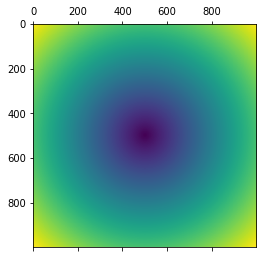

In [36]:
# azimuthal_average
scale = 1.0/(pixel_size*nx)
bins = k_minmax
print("shape",ps2d.shape)
y, x = np.indices(ps2d.shape)*float(scale)
print("y=\n",y)
print("x=\n",x)
center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
print ("center",center)
r = np.hypot(x - center[0], y - center[1])
print ("r=\n",r)
plt.matshow(r)
bin_centers = 0.5*(bins[1:]+bins[:-1])
print("bins=\n",bins)
print ("bin_centers=\n",bin_centers)
nr = np.histogram(r,bins)[0]


radial_prof = np.histogram(r, bins, weights=image)[0] / np.histogram(r, bins)[0]

return nr, bin_centers, radial_prof
